# Fitting SVG signal

In this notebook I will take a random sample of points from the SVG smoothed signal (created in Sunspot Data Plotting) and see if the Gaussian process can (essentially) fill in the rest of the points.

For this I will be using the ***qusi-periodic kernel function***, given by:

$$ k_{i,j} = A^2 \exp{\left[-\frac{(x_i-x_j)^2}{2 l^2} - \sin^2{\left(\frac{\pi (x_i - x_j)}{P} \right)} \right]} + \sigma^2 \delta_{ij}$$

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az

In [2]:
df = pd.read_csv('Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values
yerr = np.zeros(len(X)) 

In [45]:
rng = np.random.RandomState(1) # random selection of points
training_indices = rng.choice(np.arange(y.size), size=200, replace=False)

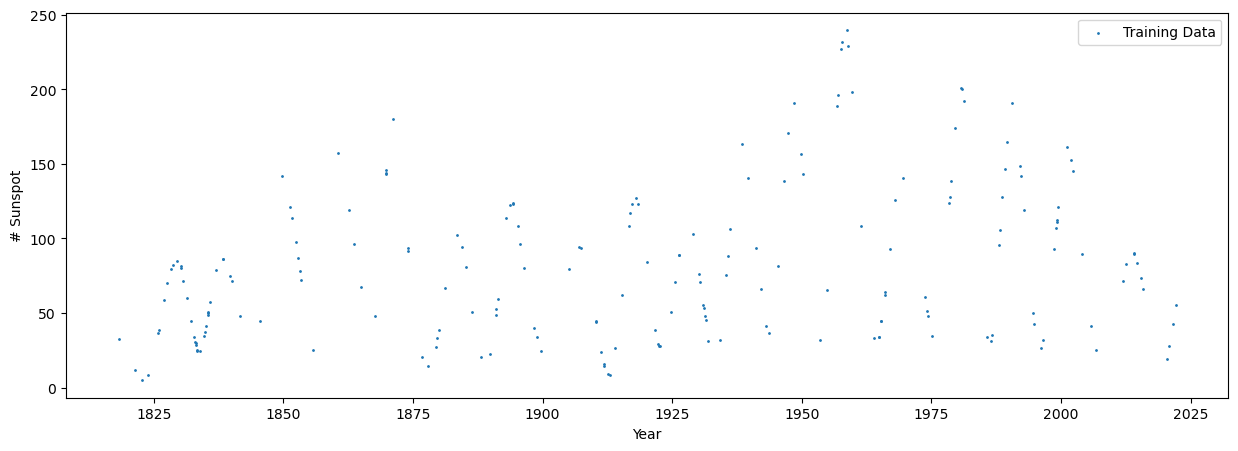

In [46]:
X_train = X[training_indices] # x & y values of random indicies
y_train = y[training_indices]

fig, ax = plt.subplots(1, dpi=100, figsize=[15,5])

ax.scatter(X_train, y_train, label='Training Data', s=1)
ax.set_xlabel('Year')
ax.set_ylabel("# Sunspot")
ax.legend();

Here we are taking a sample of points from our data (which contains over 70,000 datapoints). The training data represents most of the shape of the distribution, so we will observe how well it can be modelled using a Gaussian process.

PyMC3 doesn't contain the quasi-periodic kernel, but it *does* contain a **periodic kernel** as well as a **squared exponential kernel**, which we can multiply togehter to arrive at our desired kernel.

In [47]:
with pm.Model() as model:
    
    period = pm.Normal('Period', 11, 1)
    A = pm.Gamma('A', 2, 2)
    length_scale1 = pm.Deterministic('Length Scale 1', 
                                    pm.Beta('ls1', 2, 2) * 100)
    length_scale2 = pm.Deterministic('Length Scale 2', 
                                    pm.Beta('ls2', 2, 2)* 10 + 7)
    sigma = pm.Beta('$\sigma$', 2, 2)
    
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1) # periodic kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2) # squared exponential kernel
    cov_qp = A**2 * cov_SE * cov_periodic # quasi-periodic kernel
    
    mu = pm.Normal('mu', 100, 50) # note: using LogNormal makes no difference
    const_func = pm.gp.mean.Constant(mu)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=const_func)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, $\sigma$, ls2, ls1, A, Period]


/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 188 seconds.


The above code required a lot of trial and error to see at which points the priors converge to their optimal values, and continued readjustment of priors eventually lead to the values we have below.

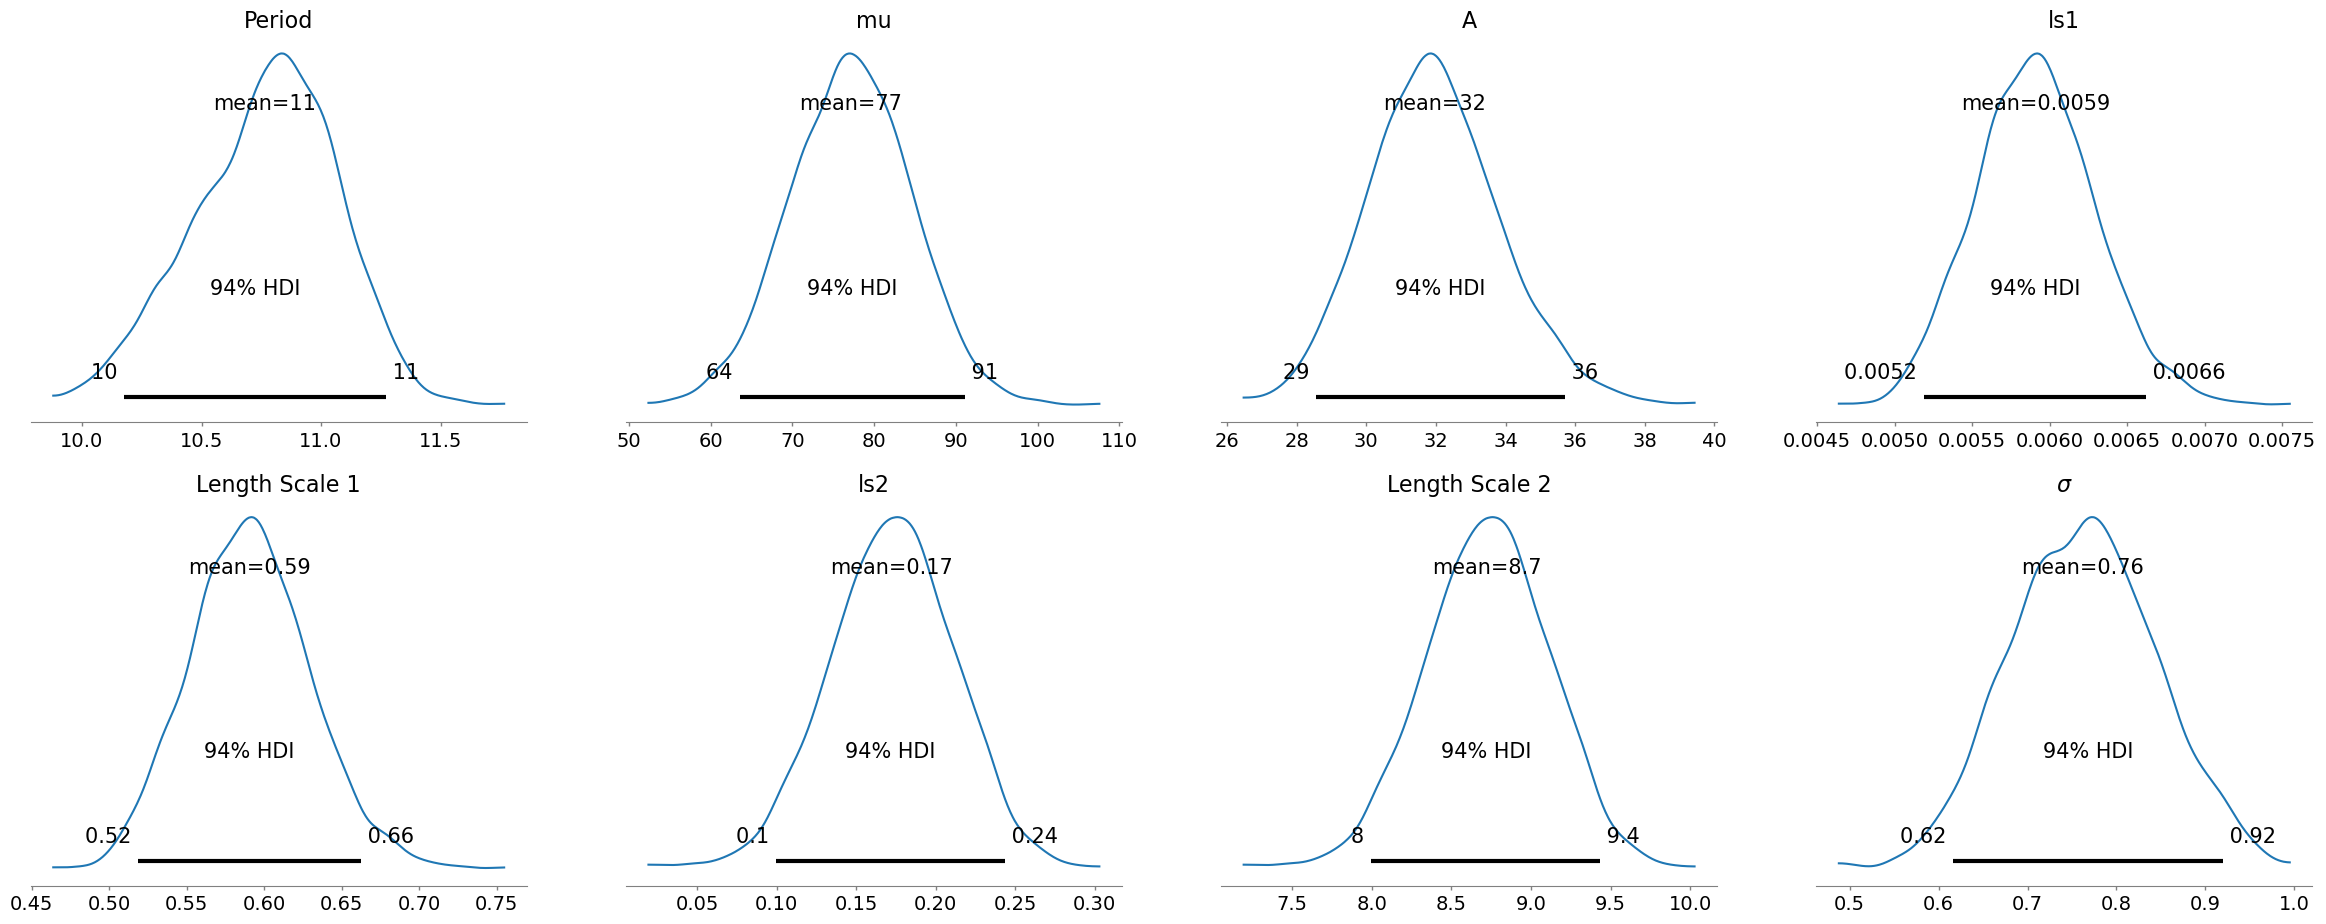

In [48]:
az.plot_posterior(tr);

In [49]:
X_new = np.linspace(1800, 2055, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=100, var_names=["f_new"])#

/Applications/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


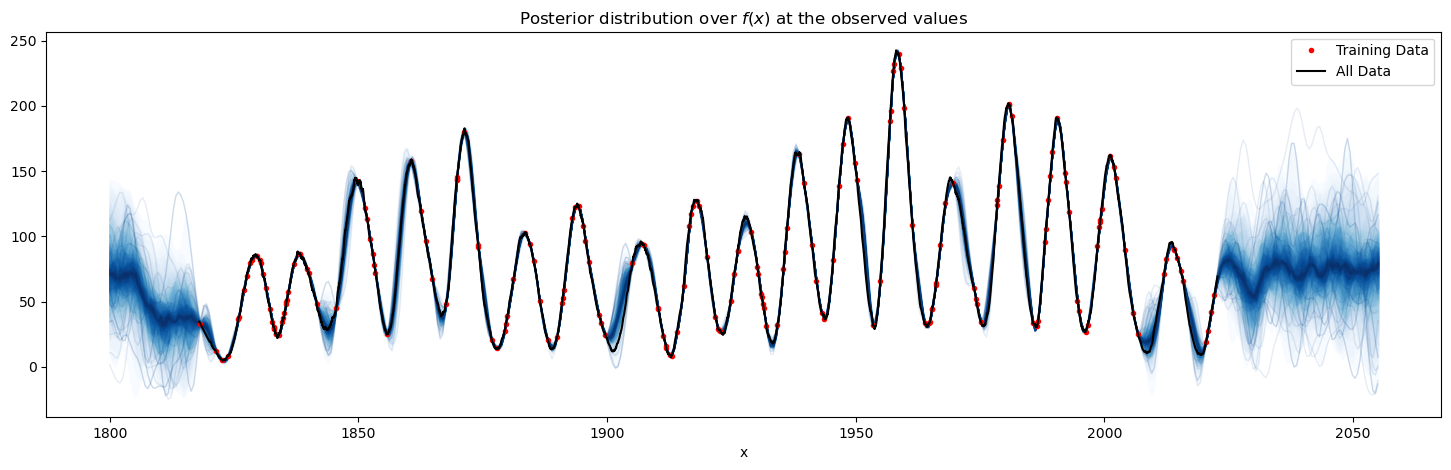

In [50]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(18, 5))
ax = fig.gca()
plot_gp_dist(ax, ppc['f_new'], X_new, palette="Blues")

# plot original data and true function
plt.plot(X_train, y_train, "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")

plt.xlabel("x")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

#### Comment on plot:

Here we have used a ***quasi-periodic kernel*** consisting of only 100 data points. The GP does a very good job of modelling the data given the sparsity of data, however there is a recurrent issue with our parameter *length_scale1*, which is far too small and refuses to converge on anything else. This results in new predictions which do not show the same periodic behaivour, as the knowledge of the model essentially dies after that time.

### Forcing the parameters

In [51]:
with pm.Model() as model:
    
    period = pm.Normal('Period', 11, 1)
    ''' Parameters from above '''
    A = 32
    length_scale2 = 9
    sigma = 0.76
    length_scale1 = 10 # the 'forced' parameter
    
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1) # periodic kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2) # squared exponential kernel
    cov_qp = A**2 * cov_SE * cov_periodic # quasi-periodic kernel
    
    mu = 77 # note: using LogNormal makes no difference
    const_func = pm.gp.mean.Constant(mu)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=const_func)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Period]


/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Applications/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
The acceptance probability does not match the target. It is 0.884715333916832, but should be close to 0.8. Try to increase the number of tuning steps.


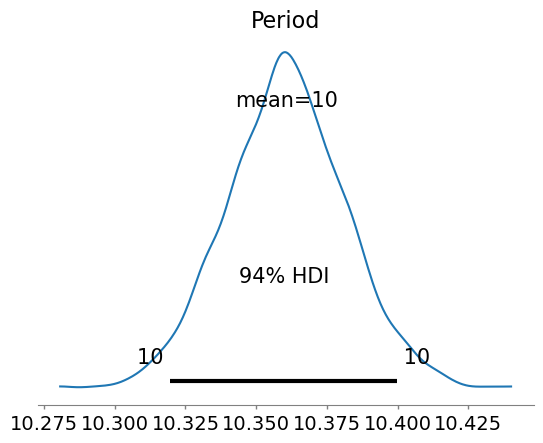

In [52]:
az.plot_posterior(tr);

In [ ]:
X_new = np.linspace(1800, 2055, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=100, var_names=["f_new"])#

/Applications/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [ ]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(18, 5))
ax = fig.gca()
plot_gp_dist(ax, ppc['f_new'], X_new, palette="Blues")

# plot original data and true function
plt.plot(X_train, y_train, "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")

plt.xlabel("x")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

### Comment on plot:

For the above plot we chose the optimized parameters from the previous sampling, however I chose to 'force' the parameter for *length_scale1* as 10 years, so that the code would remember the shape of previous cycles better. The effect of doing this is that it has at least given some form of prediction for before and after our first and final cycles respectively. The drawback is that, as we can see, the fitting is not nearly as accurate as the previous one, and the prediction for cycle 25 doesn't look accurate as there is never a proper descent from its peak.

## Fitting with TensorFlow

At some point throughout this project I will want to create a neural network, which will involve the use of TensorFlow. Before creating the NN I first want to be able to use a GP with TF.

In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def build_gp(amplitude, length_scale1, length_scale2, period, observation_noise_variance):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
    cov_SE = tfk.ExponentiatedQuadratic(amplitude, length_scale1)
    cov_P = tfk.ExpSinSquared(1, length_scale2, period)
    kernel = cov_SE * cov_P
    
  # Create the GP prior distribution, which we will use to train the model
  # parameters.
    return tfd.GaussianProcess(
      kernel=kernel,
      index_points=X_train,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'period': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale1': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale2': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

In [ ]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

In [ ]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale1_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale1',
    dtype=np.float64)

length_scale2_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale2',
    dtype=np.float64)

period_var = tfp.util.TransformedVariable(
    initial_value=11.,
    bijector=constrain_positive,
    name='period',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale1_var,
                        length_scale2_var,
                        period_var,
                       observation_noise_variance_var]]

In [ ]:
def target_log_prob(amplitude, length_scale1, length_scale2, period, observation_noise_variance):
    return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale1': length_scale1,
        'length_scale2': length_scale2,
        'period': period,
      'observation_noise_variance': observation_noise_variance,
      'observations': y_train
  })

In [ ]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(amplitude_var, length_scale1_var,
                                length_scale2_var, period_var,
                              observation_noise_variance_var)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model()
    lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale1: {}'.format(length_scale1_var._value().numpy()))
print('length_scale2: {}'.format(length_scale2_var._value().numpy()))
print('period: {}'.format(period_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

**NOTE**: Period is given as 1 year... this is not correct.

In [ ]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [ ]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(1800, 2055, 500)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_SE = tfk.ExponentiatedQuadratic(amplitude_var, length_scale1_var)
optimized_P = tfk.ExpSinSquared(1, length_scale2_var, period_var)
optimized_kernel = optimized_P * optimized_SE
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=X_train,
    observations=y_train,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

In [ ]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(X, y,
         label='True fn')
plt.scatter(X_train, y_train,
            label='Observations')
for i in range(num_samples):
    plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

### Comment on plot:

TensorFlow is much faster than PyMC3, however I am unsure how I can add a Mean Function to it, as currently the predictions fall back to 0.